Differences between tf and torch ssim implementation

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from typing import Optional
import tensorflow as tf

reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch0/reconstructions/'
GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/multicoil_test_full/'
file = 'file_brain_AXFLAIR_200_6002441.h5'

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction = h5py.File(reconstruction_path, 'r')


In [3]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']


In [4]:
GT = np.array(GT)
reconstruction = np.array(reconstruction)


In [5]:
def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )
        #ssim = ssim + structural_similarity(
        #    gt[slice_num], pred[slice_num], data_range=maxval,
        #    gaussian_weights=True,
        #    sigma=0.1,
        #    win_size=3
        #)

    return ssim / gt.shape[0]


In [11]:
def ssim_tf(gt, pred, maxval=None):
    gt_tf = tf.expand_dims(tf.convert_to_tensor(gt), axis=-1)
    pred_tf = tf.expand_dims(tf.convert_to_tensor(pred), axis=-1)
    maxval = tf.math.reduce_max(gt_tf) if maxval is None else maxval
    #ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval,filter_size=3,filter_sigma=0.1))
    ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval))
    return ssim


In [7]:
ssim(GT, reconstruction)


array([0.42362654])

In [12]:
ssim_tf(GT, reconstruction)


<tf.Tensor: shape=(), dtype=float32, numpy=0.43412426>

Does cropping influence metric values?

In [1]:
### DeepMRIRec version 4 - Own Version with data normalization

import os
import h5py
import random
from pygrappa import grappa
from numpy import fft 
import time
import matplotlib.pyplot as plt
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU, add, Attention, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model

crop_size = (12,640,320)

model = None
kernel_size = (3,3)
loss_weights = [1.0, 0.000001]

def ssim_tf(gt_tf, pred_tf, maxval=None):
    maxval = tf.math.reduce_max(gt_tf) if maxval is None else maxval
    ssim = tf.reduce_mean(tf.image.ssim(img1=gt_tf,img2=pred_tf,max_val=maxval))
    return ssim

def model_loss_all(y_true, y_pred):
    global loss_weights
    
    ssim_loss = 1 - ssim_tf(y_true, y_pred)
    l1_loss = tf.reduce_sum(tf.math.abs(y_true-y_pred))
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*l1_loss

def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top = BatchNormalization()(layer_top)

    res_model = LeakyReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization()(res_model)

    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = LeakyReLU()(res_model)
    return res_model

def encoder(inp, nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    return layers, skip_layers

def decoder(inp, nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers

def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op = decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    op = Activation('linear', dtype='float32')(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape = (crop_size[1],crop_size[2],crop_size[0])
input_layer = Input(shape=input_shape)
model = create_gen(input_layer,5,32,0.01)
model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/UnaugmentedExtensiveSavesOwnVersion/DeepMRIRec_trained_in_small_batches_GPU_epoch77.h5')

# Load test data

download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
test_path = os.path.join(download_path,'multicoil_test')
test_target_path = os.path.join(download_path,'multicoil_test_full')

#file_name = 'file_brain_AXFLAIR_201_6002891.h5'
file_name = 'file_brain_AXT2_205_6000143.h5'

def calculate_mask(mask,start,end,nPE):
    '''
    The mask contains more information from the center of k-space. 
    We divide phase encoding space into nine areas/slots (see Figure 3 from paper, nine slots are separated by red dotted lines) 
    and select 10% of data points from the center area and 4%, 2%,1%, and 0.5% from the area adjacent to the centers
    In total, we thus retain 10% + (4+2+1+0.5)*2 % = 25% of the original k-space. This way, we obtain R=4.
    '''
    
    total_point = start
    max_len = nPE
    number_of_sample = (max_len/4)-(end-start)
    step = int((4*start)/number_of_sample)
    i = step
    f = 1
    indx = 1
    while i < total_point+1:
        offset = 10 + int(random.sample(range(0,3), 1)[0])
        if offset+i < total_point:
            mask[:,:,:,offset+i] = 1
        else:
            mask[:,:,:,i] = 1

        offset = 5 + int(random.sample(range(0,3), 1)[0])
        if i-offset > 0:
            mask[:,:,:,max_len-i-offset] = 1
        else:
            mask[:,:,:,max_len-i] = 1
        i = i+step
        indx = indx+1
        if i >= ((total_point*f)//2):
            step = int(step/3)
            f = f+1
    return mask

def Grappa_recon(kspace,start, end):
    calib = kspace[:,:,start:end].copy()
    res = grappa(kspace, calib, kernel_size=(5,5),coil_axis=0)
    return res

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]

last_mask = None
X_test = []
Y_test = []

with h5py.File(os.path.join(test_target_path, file_name),'r') as f:

    k = f['kspace'][()]
    sequence = f.attrs['acquisition']
    nSL, nCh, nFE, nPE = k.shape
     
    # Select ACS region
    mid = nPE//2
    start = mid-int(nPE*0.05)
    end = mid+int(nPE*0.05)
       
    mask = 0*k
    mask[:,:,:,start:end] = 1
    mask = calculate_mask(mask,start,end,nPE)  
    last_mask = mask
    subsampled_k = k*mask
    ts = time.time()
    if nCh > 18:
        channels_picked = [0,1,2,4,7,8,11,13,15,16,17,18]
    elif nCh > 12 and nCh < 18:
        channels_picked = [0,1,2,3,4,5,6,7,8,10,11,12]
    else:
        channels_picked = []
    if len(channels_picked)>0:
        for slices in range(nSL): 
            chindx = 0
            ref_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            sub_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            subsampled_tmp = Grappa_recon(subsampled_k[slices,:,:,:],start,end)    
            for iCh in channels_picked:
                sub_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(subsampled_tmp[iCh,:,:])))
                ref_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(k[slices,iCh,:,:])))
                chindx = chindx+1
            X_test.append(list(comp_img(sub_img,crop_size)))
            Y_test.append(list(comp_img(ref_img,crop_size)))
        print(sequence,nSL,nCh,nFE,nPE,sub_img.shape,"ACS region indices: ",start,end,"Processing time: ",time.time()-ts)
X_test_arr = np.array(X_test).astype(np.float32)
Y_test_arr = np.array(Y_test).astype(np.float32)
print("X_test and Y_test constructed with shapes: ",X_test_arr.shape,Y_test_arr.shape)

X_test_arr = np.transpose(X_test_arr,(0,2,3,1))
Y_test_arr = np.transpose(Y_test_arr,(0,2,3,1))

Y_rss = np.sqrt(np.sum(np.square(Y_test_arr),axis=3))
Y_rss = Y_rss.astype(np.float32)

def normalize(data, mean, std, eps=0.0):
    return (data - mean) / (std + eps)

def normalize_instance(data, eps=0.0):
    mean = np.mean(data)
    std = np.std(data)
    return normalize(data, mean, std, eps), mean, std

dims = X_test_arr.shape

for i in range(dims[0]):
    for j in range(dims[-1]):
        X_test_arr[i,:,:,j], _, _ = normalize_instance(X_test_arr[i,:,:,j])
        X_test_arr[i,:,:,j] = np.clip(X_test_arr[i,:,:,j], -6, 6)

for i in range(dims[0]):
    Y_rss[i,:,:], _, _ = normalize_instance(Y_rss[i,:,:])
    Y_rss[i,:,:] = np.clip(Y_rss[i,:,:], -6, 6)

# Make prediction with our model
reconstructed_test_image = model.predict(X_test_arr)
reconstructed_test_image = reconstructed_test_image[:,:,:,0]


AXT2 16 16 640 320 (12, 640, 320) ACS region indices:  144 176 Processing time:  133.54403829574585
X_test and Y_test constructed with shapes:  (16, 12, 640, 320) (16, 12, 640, 320)


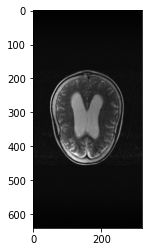

In [2]:
slice = 3

test_target_slice_image = Y_rss[slice,:,:]

# Ground truth of the test slice
plt.imshow(test_target_slice_image, cmap = 'gray')


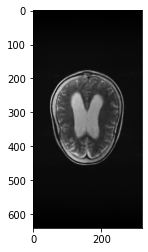

In [3]:
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [4]:
def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


In [5]:
print(nmse(Y_rss,reconstructed_test_image))
print(psnr(Y_rss,reconstructed_test_image))
print(ssim(Y_rss,reconstructed_test_image))


0.051518453408190015
28.483267197572765
[0.75634633]


In [6]:
Y_rss_cropped = comp_img(Y_rss,(dims[0],320,320))
reconstructed_test_image_cropped = comp_img(reconstructed_test_image,(dims[0],320,320))


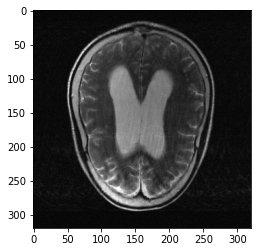

In [7]:
# Ground truth of the test slice
plt.imshow(Y_rss_cropped[slice,:,:], cmap = 'gray')


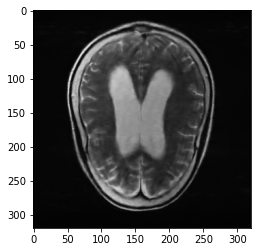

In [8]:
plt.imshow(reconstructed_test_image_cropped[slice,:,:], cmap='gray')


In [9]:
print(nmse(Y_rss_cropped,reconstructed_test_image_cropped))
print(psnr(Y_rss_cropped,reconstructed_test_image_cropped))
print(ssim(Y_rss_cropped,reconstructed_test_image_cropped))


0.04942357240126088
26.351181663106956
[0.68455374]


Does BART scale its output differently, affecting the evaluation metrics?

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

reconstruction_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/Sense/reconstructions/'
reconstruction_ZF_path = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/ZeroFilled/reconstructions/'
GT_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed/multicoil_test_full/'
file = 'file_brain_AXFLAIR_209_6001340.h5'

GT_path = os.path.join(GT_path,file)
reconstruction_path = os.path.join(reconstruction_path,file)
reconstruction_ZF_path = os.path.join(reconstruction_ZF_path,file)

GT = h5py.File(GT_path, 'r')
reconstruction = h5py.File(reconstruction_path, 'r')
reconstruction_ZF = h5py.File(reconstruction_ZF_path, 'r')


In [2]:
GT = GT['reconstruction_rss']
reconstruction = reconstruction['reconstruction']
reconstruction_ZF = reconstruction_ZF['reconstruction']


In [3]:
GT = np.array(GT)
reconstruction = np.array(reconstruction)
reconstruction_ZF = np.array(reconstruction_ZF)


In [4]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]

reconstruction = comp_img(reconstruction,(reconstruction.shape[0],320,320))
reconstruction_ZF = comp_img(reconstruction_ZF,(reconstruction_ZF.shape[0],320,320))


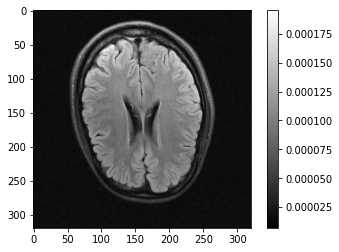

In [8]:
plt.imshow(GT[3], cmap='gray')
plt.colorbar()


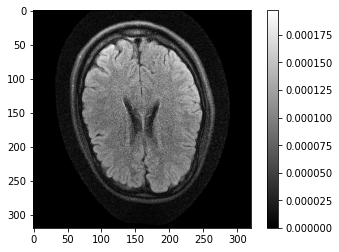

In [9]:
plt.imshow(reconstruction[3], cmap='gray')
plt.colorbar()


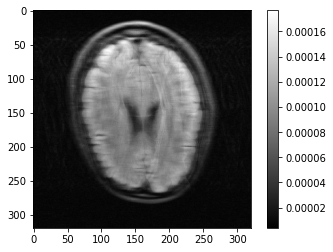

In [10]:
plt.imshow(reconstruction_ZF[3], cmap='gray')
plt.colorbar()


In [11]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE)"""
    return np.array(np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2)

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max() if maxval is None else maxval

    ssim = np.array([0])
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(
            gt[slice_num], pred[slice_num], data_range=maxval
        )

    return ssim / gt.shape[0]


In [12]:
print(nmse(GT, reconstruction))
print(psnr(GT, reconstruction))
print(ssim(GT, reconstruction))


0.07639790365845296
23.772238334133053
[0.34221341]


In [13]:
print(nmse(GT, reconstruction_ZF))
print(psnr(GT, reconstruction_ZF))
print(ssim(GT, reconstruction_ZF))


0.0385836160540446
26.739022034685696
[0.6945138]


In [14]:
def normalize(
    data,
    mean,
    stddev,
    eps = 0.0,
):
    """
    Normalize the given input.

    Applies the formula (data - mean) / (stddev + eps).

    Args:
        data: Input data to be normalized.
        mean: Mean value.
        stddev: Standard deviation.
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        Normalized data.
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data, eps = 0.0
):
    """
    Normalize the given input with instance norm

    Applies the formula (data - mean) / (stddev + eps), where mean and stddev
    are computed from the data itself.

    Args:
        data: Input data to be normalized
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        Normalized data
    """
    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std


In [15]:
norm_GT, mean_GT, std_GT = normalize_instance(GT)
norm_reconstruction, mean_recon, std_recon = normalize_instance(reconstruction)
norm_reconstruction_ZF, mean_recon_ZF, std_recon_ZF = normalize_instance(reconstruction_ZF)


In [16]:
print(nmse(norm_GT, norm_reconstruction))
print(psnr(norm_GT, norm_reconstruction))
print(ssim(norm_GT, norm_reconstruction))


0.05402084256990772
26.880408515776896
[0.63041519]


In [17]:
print(nmse(GT, reconstruction_ZF))
print(psnr(GT, reconstruction_ZF))
print(ssim(GT, reconstruction_ZF))


0.0385836160540446
26.739022034685696
[0.6945138]


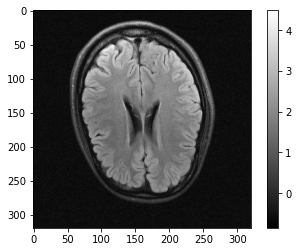

In [18]:
plt.imshow(norm_GT[3], cmap='gray')
plt.colorbar()


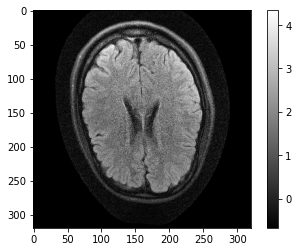

In [19]:
plt.imshow(norm_reconstruction[3], cmap='gray')
plt.colorbar()


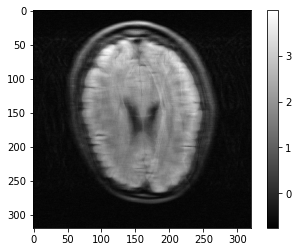

In [20]:
plt.imshow(norm_reconstruction_ZF[3], cmap='gray')
plt.colorbar()


Is VGG loss a better evaluation metric perhaps?

In [38]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

selected_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3' ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01, 2, 4]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(320,320,3))
vgg.trainable = False

outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable = False

def vgg_loss(y_true, y_pred):
    global vgg_model
    global selected_layer_weights_content

    y_true_batch = tf.expand_dims(tf.convert_to_tensor(y_true),-1)
    y_pred_batch = tf.expand_dims(tf.convert_to_tensor(y_pred),-1)

    content_loss = 0.0

    res_y_rss = tf.image.grayscale_to_rgb(y_true_batch*255)
    res_y_rss = preprocess_input(res_y_rss)
    vgg_f_gt = vgg_model(res_y_rss)

    res_y_pred = tf.image.grayscale_to_rgb(y_pred_batch*255)
    res_y_pred = preprocess_input(res_y_pred)
    vgg_f_pred = vgg_model(res_y_pred)

    for h1, h2, cw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content):
        content_loss = content_loss + cw *tf.reduce_mean(tf.square(tf.math.abs(tf.cast(h1,tf.float32) - tf.cast(h2,tf.float32))))

    return content_loss


In [39]:
vgg_loss(GT, reconstruction)


<tf.Tensor: shape=(), dtype=float32, numpy=0.004489363>

In [40]:
vgg_loss(GT, reconstruction_ZF)


<tf.Tensor: shape=(), dtype=float32, numpy=0.014713254>

How about in PyTorch?

In [23]:
import torch
from torchvision.models import vgg19
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Lambda

# Define the preprocessing steps
preprocess = Compose([
    ToTensor(),
    CenterCrop((224, 224)), # Ensure the center part of the image is used
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def vgg_loss(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute VGG loss metric."""
    # Load the pre-trained VGG19 model
    vgg = vgg19(pretrained=True).features

    # Remove the last max pooling layer to get the feature maps
    vgg = torch.nn.Sequential(*list(vgg.children())[:-1])

    # Initialize a list to store the losses for each image in the batch
    losses = []

    # Loop over each image in the batch
    for gt_image, pred_image in zip(gt, pred):
        # Preprocess the images
        gt_image = preprocess(gt_image)
        pred_image = preprocess(pred_image)

        # Ensure the images are batched
        gt_image = gt_image.unsqueeze(0)
        pred_image = pred_image.unsqueeze(0)

        # Extract features
        gt_features = vgg(gt_image)
        pred_features = vgg(pred_image)

        # Calculate VGG loss for the current pair of images
        loss = torch.nn.functional.mse_loss(gt_features, pred_features)
        losses.append(loss)

    # Average the losses across all images in the batch
    avg_loss = torch.mean(torch.stack(losses))

    return avg_loss.detach().cpu().numpy()


In [24]:
vgg_loss(GT, reconstruction)


array(1.9961007e-08, dtype=float32)

In [25]:
vgg_loss(GT, reconstruction_ZF)


array(4.581804e-08, dtype=float32)